# Initial Model TFLite
This is the test notebook for the inital model that we will be using for the project.
There will be a lot of changes to this model as we go on, and we will be using this notebook to test those changes.

## Setup Environment

Mac Environment Setup:
1. Create a new virtual environment with Python 3.10. Do not use the setup_env.sh script.
  - ``` python3.10 -m venv .venv ```
  - ``` source .venv/bin/activate ```
  - ``` pip install -r requirements.txt ```
2. Verify that TensorFlow is working with the GPU.
  - Check the output of the following cell. You should see something like:
    - TensorFlow version: 2.16.2 
    - Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] 
    - Result: tf.Tensor([5. 7. 9.], shape=(3,), dtype=float32) 
    - Metal device set to: Apple M1 Pro 
    - systemMemory: 16.00 GB 
    - maxCacheSize: 5.33 GB 


In [1]:
# Initial Model TFLite

## Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from IPython.display import Video

import os
import json
import shutil
import glob

# Verify TensorFlow installation
print(f"TensorFlow version: {tf.__version__}")

# Enable verbose logging
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0" 

# Check GPU devices
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

# Perform a computation
with tf.device('/GPU:0'):
    a = tf.constant([1.0, 2.0, 3.0])
    b = tf.constant([4.0, 5.0, 6.0])
    c = a + b
    print("Result:", c)


# The first time this cell is run, make sure that you see: 
# Metal device set to: Apple M[GPU]


TensorFlow version: 2.16.2
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Result: tf.Tensor([5. 7. 9.], shape=(3,), dtype=float32)


2024-11-24 11:38:19.985877: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-11-24 11:38:19.985910: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-24 11:38:19.985918: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-24 11:38:19.986386: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-24 11:38:19.986397: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [42]:
# Setup directories and filenames
NOTEBOOK_TAG = "initial_model"
MODEL_NAME = "rep_mate"

MODELS_DIR = NOTEBOOK_TAG + '/models'
DATASET_DIR = NOTEBOOK_TAG + '/dataset'
CHKPT_DIR = NOTEBOOK_TAG + '/checkpoints'
PLOT_DIR = 'plots'
ANIM_DIR = 'anim'

# Create base directories with parents
for directory in [MODELS_DIR, DATASET_DIR, CHKPT_DIR, PLOT_DIR]:
    os.makedirs(directory, exist_ok=True)

# Define model filenames
SAVED_MODEL_FILENAME = os.path.join(MODELS_DIR, MODEL_NAME)
FLOAT_TFL_MODEL_FILENAME = os.path.join(MODELS_DIR, MODEL_NAME + "_float.tfl")
QUANTIZED_TFL_MODEL_FILENAME = os.path.join(MODELS_DIR, MODEL_NAME + ".tfl")
TFL_CC_MODEL_FILENAME = os.path.join(MODELS_DIR, MODEL_NAME + ".cc")

# Define dataset directories
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR = os.path.join(DATASET_DIR, "validation")
TEST_DIR = os.path.join(DATASET_DIR, "test")

# Create dataset subdirectories
for directory in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    os.makedirs(directory, exist_ok=True)

In [3]:
CLEAR_DATA = True

# Directories to clean up
DIRS = [
    MODELS_DIR,
    DATASET_DIR,
    CHKPT_DIR,
    TRAIN_DIR,
    VAL_DIR,
    TEST_DIR
]

def remove_files_in_directory(directory):
    if not os.path.exists(directory):
        return
        
    for root, dirs, files in os.walk(directory, topdown=False):
        for name in files:
            file_path = os.path.join(root, name)
            try:
                os.unlink(file_path)
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')

def cleanup_all_files(dirs = DIRS):
    print("WARNING: This will delete all files in the following directories and their subdirectories:")
    for dir in dirs:
        if os.path.exists(dir):
            total_files = sum([len(files) for _, _, files in os.walk(dir)])
            print(f"  - {dir} ({total_files} files)")
    
    confirmation = input("\nType 'YES' to confirm deletion: ")
    
    if confirmation == "YES":
        for directory in dirs:
            if os.path.exists(directory):
                remove_files_in_directory(directory)
                print(f"Removed files from: {directory}")
        print("\nAll files have been removed while preserving directory structure.")
    else:
        print("\nOperation cancelled.")

if CLEAR_DATA:
    cleanup_all_files(DIRS)

  - initial_model/models (0 files)
  - initial_model/dataset (241 files)
  - initial_model/checkpoints (0 files)
  - initial_model/dataset/train (0 files)
  - initial_model/dataset/validation (0 files)
  - initial_model/dataset/test (0 files)
Removed files from: initial_model/models
Removed files from: initial_model/dataset
Removed files from: initial_model/checkpoints
Removed files from: initial_model/dataset/train
Removed files from: initial_model/dataset/validation
Removed files from: initial_model/dataset/test

All files have been removed while preserving directory structure.


## Import Dataset


In [4]:
# Copy all files from data into notebook dataset directory
!cp -r ../data/* {DATASET_DIR}

# Get all the files in the dataset directory
DATASET_FILES = glob.glob(os.path.join(DATASET_DIR, "*", "*", "*"))

# Print the number of files in the dataset
print(f"Number of files in dataset: {len(DATASET_FILES)}")


Number of files in dataset: 240


In [5]:
# Python list to hold the dataset
DATASET = []

# Read each file and append to the dataset, add filename to the file data
for f in DATASET_FILES:
  with open(f, "r") as file:
    f_c = file.read()
  f_d = json.loads(f_c)
  f_d["filename"] = f
  DATASET.append(f_d)

print(f"Number of files in dataset: {len(DATASET)}")

Number of files in dataset: 240


## Visualize Dataset

In [6]:
def set_matplotlib_backend(backend='inline'):
    """
    Switch matplotlib backend between 'inline' and 'notebook'
    Args:
        backend (str): Either 'inline' (static plots) or 'notebook' (interactive/animations)
    """
    from IPython import get_ipython
    ipython = get_ipython()
    ipython.run_line_magic('matplotlib', backend)

In [7]:
LIFT_NAMES = {
    "dC": "Dumbbell Curl",
    "bP": "Bench Press",
    "dF": "Dumbbell Fly"
}
LIFT_CLASSES = {
    "p_f": "Perfect Form",
    "l_i": "Lift Instability",
    "p_m": "Partial Motion",
    "o_a": "Off-Axis",
    "s_w": "Swinging Weight"
}

In [40]:
def create_lists(data):
  time, aX, aY, aZ, gX, gY, gZ = [], [], [], [], [], [], []
  for v in data:
    time.append(v['t'])
    aX.append(v['aX'])
    aY.append(v['aY'])
    aZ.append(v['aZ'])
    gX.append(v['gX'])
    gY.append(v['gY'])
    gZ.append(v['gZ'])
  return time, aX, aY, aZ, gX, gY, gZ


def plot_flat_dataset(data, show= True, save=False):
  set_matplotlib_backend('inline')
  d = data["tSD"]
  lN = data["lN"]
  lC = data["lC"]
  time, aX, aY, aZ, gX, gY, gZ = create_lists(d)

  # Create subplots for acceleration and gyroscope data
  fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

  # Acceleration subplot
  axs[0].plot(time, aX, label='Ax')
  axs[0].plot(time, aY, label='Ay')
  axs[0].plot(time, aZ, label='Az')
  axs[0].set_title('3D Acceleration Over Time')
  axs[0].set_ylabel('Acceleration (m/s^2)')
  axs[0].legend()

  # Gyroscope subplot
  axs[1].plot(time, gX, label='Gx')
  axs[1].plot(time, gY, label='Gy')
  axs[1].plot(time, gZ, label='Gz')
  axs[1].set_title('3D Gyroscope Over Time')
  axs[1].set_xlabel('Time (s)')
  axs[1].set_ylabel('Gyroscope (rad/s)')
  axs[1].legend()

  # Set Chart Title
  fig.suptitle(f"{LIFT_NAMES[lN]} - {LIFT_CLASSES[lC]}", fontsize=16)

  # Show the plots
  plt.tight_layout()
  if show:
    plt.show()

  if save:
    fig.savefig(f"{PLOT_DIR}/{LIFT_NAMES[lN]}_{LIFT_CLASSES[lC]}_flat.png")

def plot_3d_trajectory(data, show = True,save=False):
    set_matplotlib_backend('inline')
    d = data["tSD"]
    lN = data["lN"]
    lC = data["lC"]
    time, aX, aY, aZ, gX, gY, gZ = create_lists(d)

    # Normalize time for color gradient
    norm_time = (np.array(time) - min(time)) / (max(time) - min(time))

    # Create 3D scatter plot for acceleration
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(121, projection='3d')
    scatter = ax.scatter(aX, aY, aZ, c=norm_time, cmap='viridis', s=10)
    ax.plot(aX, aY, aZ, color='gray', alpha=0.5)  # Optional trajectory line
    ax.set_title('3D Acceleration Trajectory')
    ax.set_xlabel('Ax (m/s^2)')
    ax.set_ylabel('Ay (m/s^2)')
    ax.set_zlabel('Az (m/s^2)')
    fig.colorbar(scatter, ax=ax, label='Time Gradient')

    # Create 3D scatter plot for gyroscope
    ax2 = fig.add_subplot(122, projection='3d')
    scatter2 = ax2.scatter(gX, gY, gZ, c=norm_time, cmap='plasma', s=10)
    ax2.plot(gX, gY, gZ, color='gray', alpha=0.5)  # Optional trajectory line
    ax2.set_title('3D Gyroscope Trajectory')
    ax2.set_xlabel('Gx (rad/s)')
    ax2.set_ylabel('Gy (rad/s)')
    ax2.set_zlabel('Gz (rad/s)')
    fig.colorbar(scatter2, ax=ax2, label='Time Gradient')

    # Set Chart Title
    fig.suptitle(f"{LIFT_NAMES[lN]} - {LIFT_CLASSES[lC]}", fontsize=16)

    # Show the plot
    plt.tight_layout()
    if show:
      plt.show()

    if save:
      fig.savefig(f"{PLOT_DIR}/{LIFT_NAMES[lN]}_{LIFT_CLASSES[lC]}_3d.png")


In [9]:
def integrate_acceleration(time, aX, aY, aZ):
    dt = np.diff(time, prepend=time[0])  # Time differences
    # Integrate velocity
    vX = np.cumsum(aX * dt)
    vY = np.cumsum(aY * dt)
    vZ = np.cumsum(aZ * dt)
    # Integrate position
    pX = np.cumsum(vX * dt)
    pY = np.cumsum(vY * dt)
    pZ = np.cumsum(vZ * dt)
    return pX, pY, pZ


def animate_3d_trajectory(data, filename, duration_factor=1):
    set_matplotlib_backend('notebook')
    d = data["tSD"]
    lN = data["lN"]
    lC = data["lC"]
    time, aX, aY, aZ, gX, gY, gZ = create_lists(d)

    # Integrate acceleration to find position
    pX, pY, pZ = integrate_acceleration(time, aX, aY, aZ)

    # Duration and timing
    base_duration = 5  # Base duration in seconds
    total_duration = base_duration * duration_factor
    interval = (total_duration * 1000) / len(time)  # Interval in milliseconds

    fig = plt.figure(figsize=(18, 8))
    ax = fig.add_subplot(131, projection='3d')  # Acceleration
    ax2 = fig.add_subplot(132, projection='3d')  # Gyroscope
    ax3 = fig.add_subplot(133, projection='3d')  # Position

    # Set axis limits dynamically to encompass all data
    buffer = 0.1  # Add a 10% buffer for better visibility
    ax.set_xlim([min(aX) - buffer, max(aX) + buffer])
    ax.set_ylim([min(aY) - buffer, max(aY) + buffer])
    ax.set_zlim([min(aZ) - buffer, max(aZ) + buffer])

    ax2.set_xlim([min(gX) - buffer, max(gX) + buffer])
    ax2.set_ylim([min(gY) - buffer, max(gY) + buffer])
    ax2.set_zlim([min(gZ) - buffer, max(gZ) + buffer])

    ax3.set_xlim([min(pX) - buffer, max(pX) + buffer])
    ax3.set_ylim([min(pY) - buffer, max(pY) + buffer])
    ax3.set_zlim([min(pZ) - buffer, max(pZ) + buffer])

    # Styling for Acceleration
    scatter_acc = ax.scatter([], [], [], c=[], cmap='viridis', s=100)
    trajectory_acc, = ax.plot([], [], [], color='blue', alpha=0.6, linewidth=2)
    ax.grid(True)
    ax.set_title('3D Acceleration Animation', fontsize=14)
    ax.set_xlabel('Ax (m/s^2)', fontsize=12)
    ax.set_ylabel('Ay (m/s^2)', fontsize=12)
    ax.set_zlabel('Az (m/s^2)', fontsize=12)

    # Styling for Gyroscope
    scatter_gyro = ax2.scatter([], [], [], c=[], cmap='plasma', s=100)
    trajectory_gyro, = ax2.plot([], [], [], color='red', alpha=0.6, linewidth=2)
    ax2.grid(True)
    ax2.set_title('3D Gyroscope Animation', fontsize=14)
    ax2.set_xlabel('Gx (rad/s)', fontsize=12)
    ax2.set_ylabel('Gy (rad/s)', fontsize=12)
    ax2.set_zlabel('Gz (rad/s)', fontsize=12)

    # Styling for Position
    scatter_pos = ax3.scatter([], [], [], c=[], cmap='cool', s=100)
    trajectory_pos, = ax3.plot([], [], [], color='green', alpha=0.6, linewidth=2)
    ax3.grid(True)
    ax3.set_title('3D Position Animation (From Acceleration)', fontsize=14)
    ax3.set_xlabel('Px (m)', fontsize=12)
    ax3.set_ylabel('Py (m)', fontsize=12)
    ax3.set_zlabel('Pz (m)', fontsize=12)

    # Set Chart Title
    fig.suptitle(f"{LIFT_NAMES[lN]} - {LIFT_CLASSES[lC]}", fontsize=16)

    def init():
        scatter_acc.set_offsets(np.empty((0, 3)))
        scatter_gyro.set_offsets(np.empty((0, 3)))
        scatter_pos.set_offsets(np.empty((0, 3)))
        trajectory_acc.set_data([], [])
        trajectory_acc.set_3d_properties([])
        trajectory_gyro.set_data([], [])
        trajectory_gyro.set_3d_properties([])
        trajectory_pos.set_data([], [])
        trajectory_pos.set_3d_properties([])
        return scatter_acc, scatter_gyro, scatter_pos, trajectory_acc, trajectory_gyro, trajectory_pos

    def update(frame):
        # Acceleration
        x_acc, y_acc, z_acc = aX[:frame+1], aY[:frame+1], aZ[:frame+1]
        scatter_acc._offsets3d = (x_acc, y_acc, z_acc)
        trajectory_acc.set_data(x_acc, y_acc)
        trajectory_acc.set_3d_properties(z_acc)

        # Gyroscope
        x_gyro, y_gyro, z_gyro = gX[:frame+1], gY[:frame+1], gZ[:frame+1]
        scatter_gyro._offsets3d = (x_gyro, y_gyro, z_gyro)
        trajectory_gyro.set_data(x_gyro, y_gyro)
        trajectory_gyro.set_3d_properties(z_gyro)

        # Position
        x_pos, y_pos, z_pos = pX[:frame+1], pY[:frame+1], pZ[:frame+1]
        scatter_pos._offsets3d = (x_pos, y_pos, z_pos)
        trajectory_pos.set_data(x_pos, y_pos)
        trajectory_pos.set_3d_properties(z_pos)

        return scatter_acc, scatter_gyro, scatter_pos, trajectory_acc, trajectory_gyro, trajectory_pos

    ani = FuncAnimation(fig, update, frames=len(time), init_func=init, blit=False, interval=interval)

    # Save the animation
    ani.save(filename, writer='ffmpeg', fps=1000 // interval)
    print(f'Animation saved as {filename}')



In [10]:
# Check if the directory already exists
if not os.path.exists(ANIM_DIR):
    try:
        # Create the directory
        os.makedirs(ANIM_DIR)
        print(f"Directory '{ANIM_DIR}' created successfully.")
    except Exception as e:
        # Handle any exceptions that occur during directory creation
        print(f"Error creating directory '{ANIM_DIR}': {e}")
else:
    print(f"Directory '{ANIM_DIR}' already exists.")


Directory 'anim' already exists.


In [36]:
# 16: Lift Instability
# 28: Swinging Weight
# 55: Off-Axis
# 99: Partial Motion
# 231: Perfect Form
SAVE = False

if SAVE:
  for i in [16, 28, 55, 99, 231]:
    data = DATASET[i]
    EXT = ".mp4"
    anim_filename = f"{ANIM_DIR}/{str(LIFT_NAMES[data['lN']]).replace('.json','')}_{str(LIFT_CLASSES[data['lC']])}_{EXT}".replace(" ", "_")
    animate_3d_trajectory(data, filename=anim_filename)

/var/folders/8l/gr16nv9s7fn0f9007rh084zw0000gn/T/ipykernel_52536/2849952621.py:9: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic(f'matplotlib {backend}')


<IPython.core.display.Javascript object>

Animation saved as anim/Dumbbell_Curl_Lift_Instability_.mp4


/var/folders/8l/gr16nv9s7fn0f9007rh084zw0000gn/T/ipykernel_52536/2849952621.py:9: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic(f'matplotlib {backend}')


<IPython.core.display.Javascript object>

Animation saved as anim/Dumbbell_Curl_Swinging_Weight_.mp4


/var/folders/8l/gr16nv9s7fn0f9007rh084zw0000gn/T/ipykernel_52536/2849952621.py:9: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic(f'matplotlib {backend}')


<IPython.core.display.Javascript object>

Animation saved as anim/Dumbbell_Curl_Off-Axis_.mp4


/var/folders/8l/gr16nv9s7fn0f9007rh084zw0000gn/T/ipykernel_52536/2849952621.py:9: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic(f'matplotlib {backend}')


<IPython.core.display.Javascript object>

Animation saved as anim/Dumbbell_Curl_Partial_Motion_.mp4


/var/folders/8l/gr16nv9s7fn0f9007rh084zw0000gn/T/ipykernel_52536/2849952621.py:9: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic(f'matplotlib {backend}')


<IPython.core.display.Javascript object>

Animation saved as anim/Dumbbell_Curl_Perfect_Form_.mp4


In [39]:
# Video("anim/Dumbbell_Curl_Off-Axis_.mp4", embed=True)
# Video("anim/Dumbbell_Curl_Lift_Instability.mp4", embed=True)
# Video("anim/Dumbbell_Curl_Partial_Motion.mp4", embed=True)
# Video("anim/Dumbbell_Curl_Swinging_Weight.mp4", embed=True)
# Video("anim/Dumbbell_Curl_Perfect_Form.mp4", embed=True)

/var/folders/8l/gr16nv9s7fn0f9007rh084zw0000gn/T/ipykernel_52536/2849952621.py:9: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic(f'matplotlib {backend}')


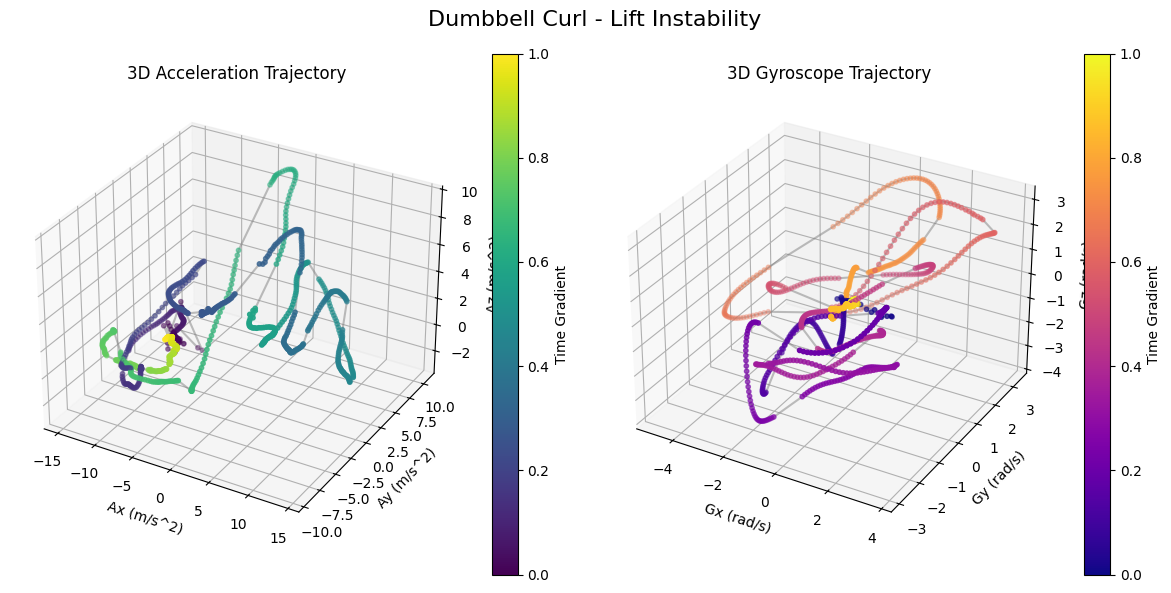

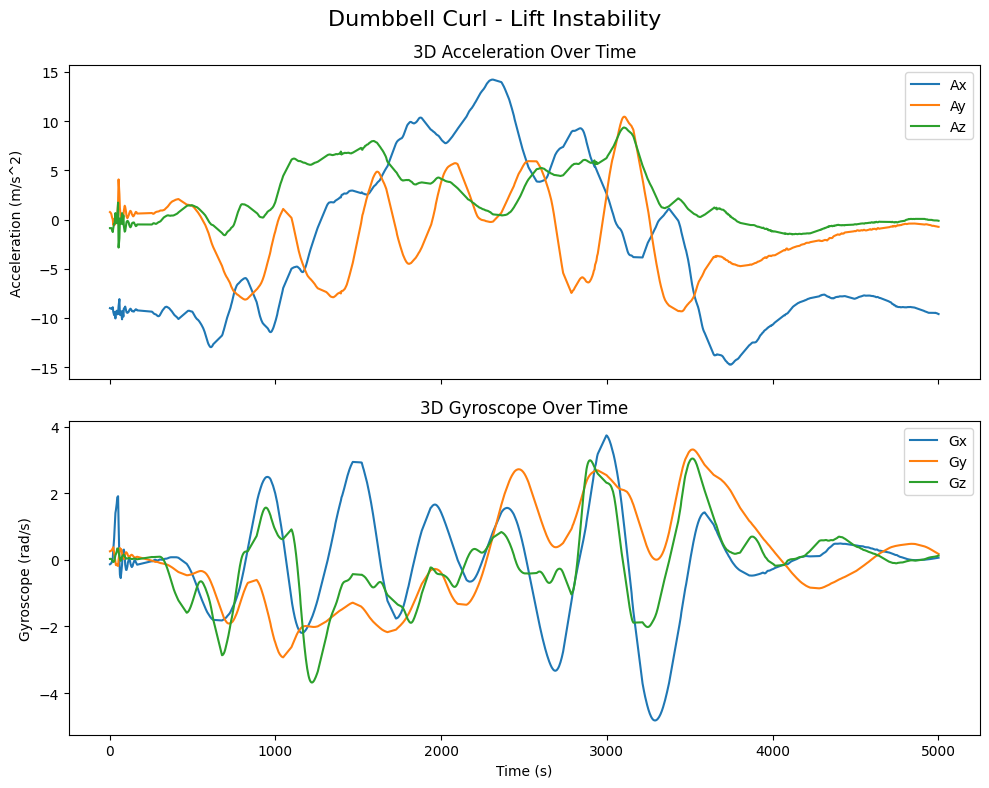

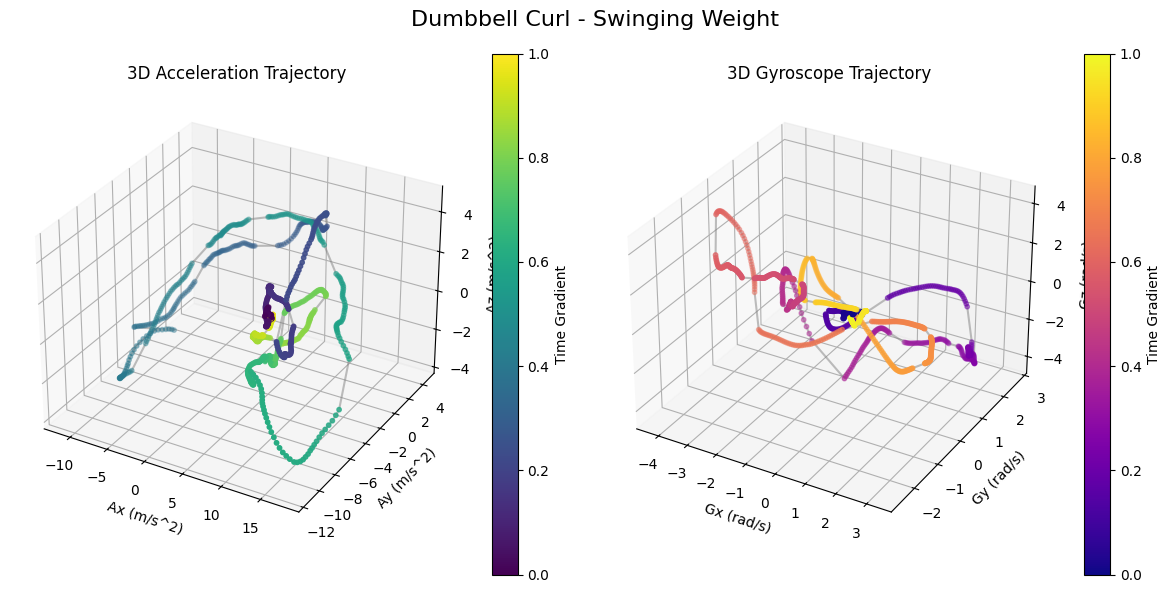

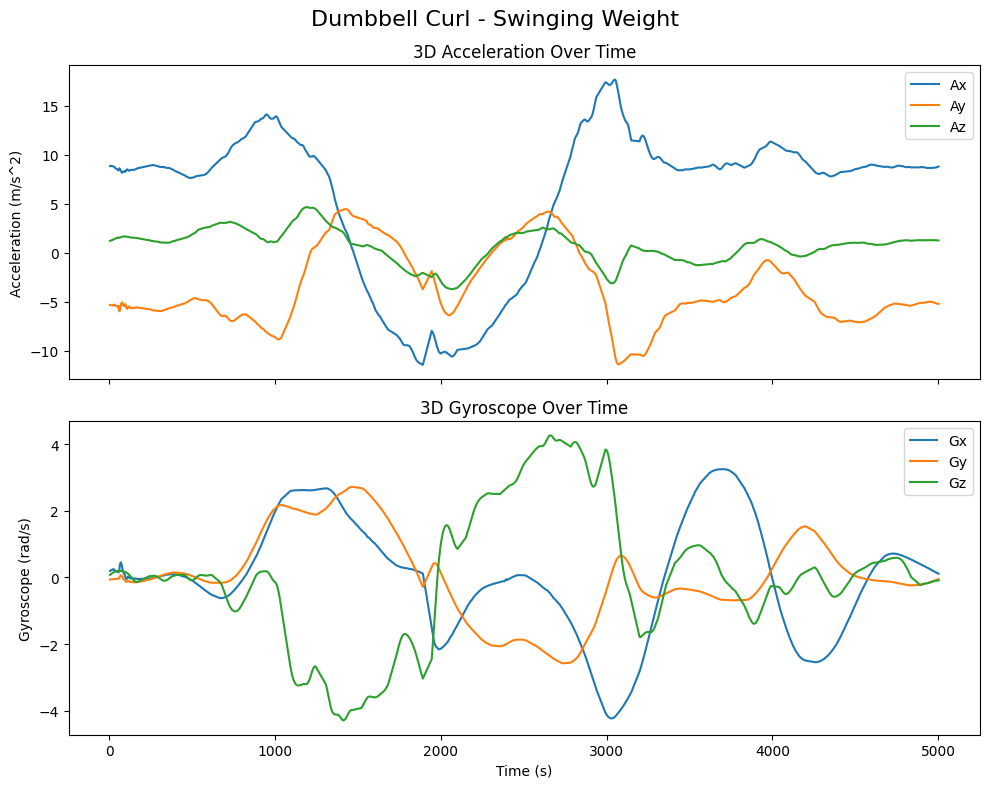

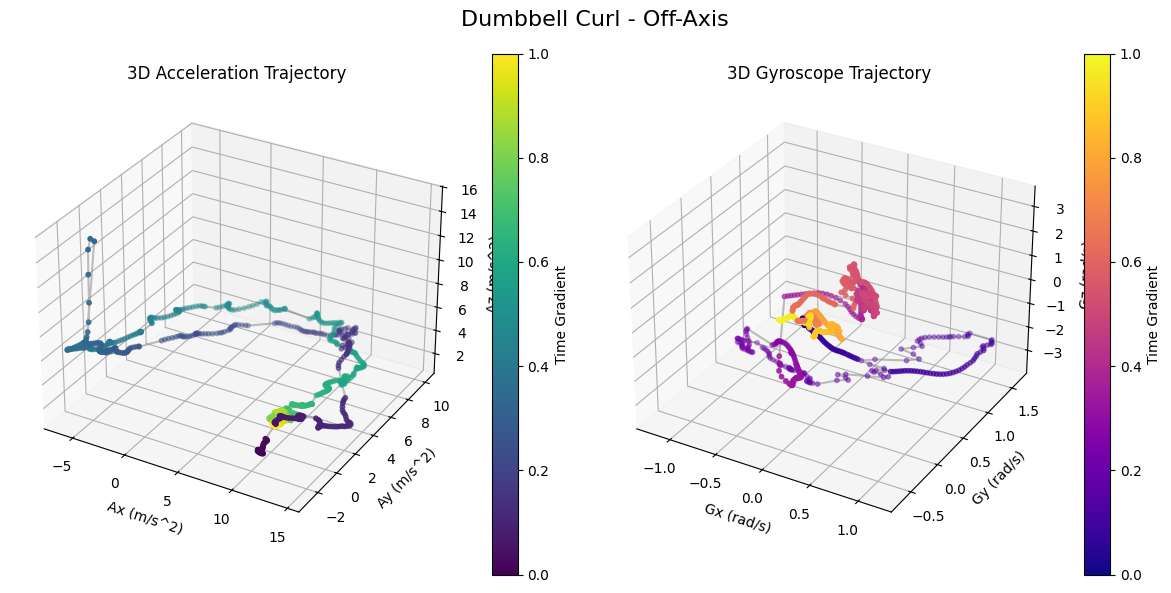

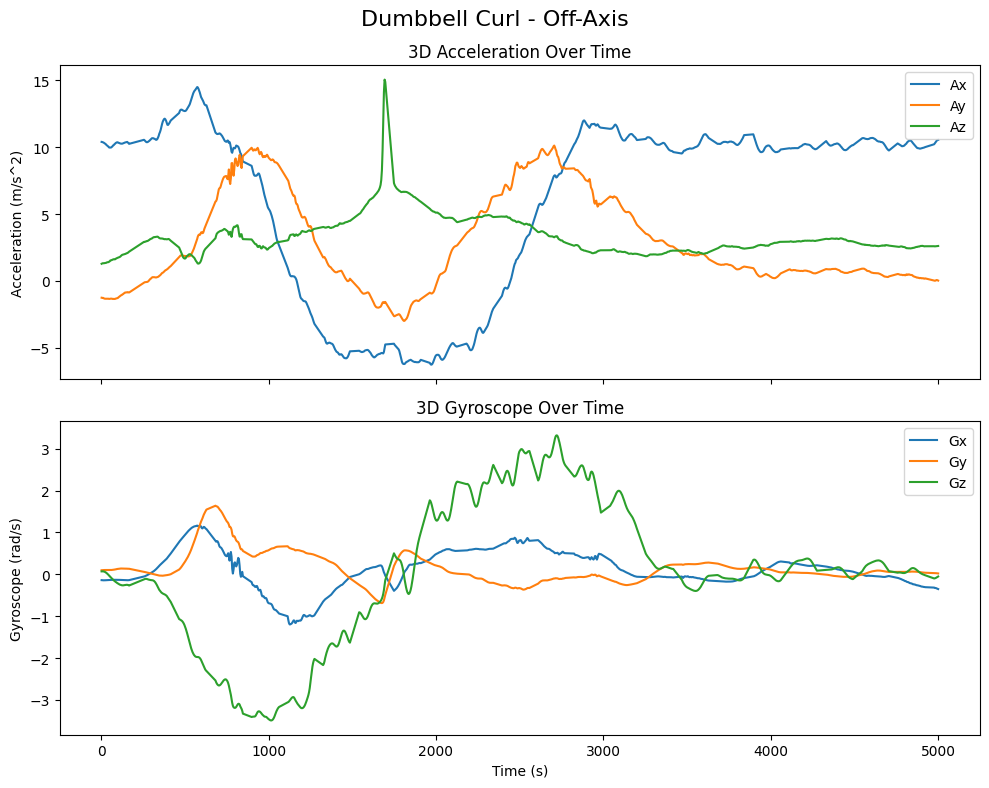

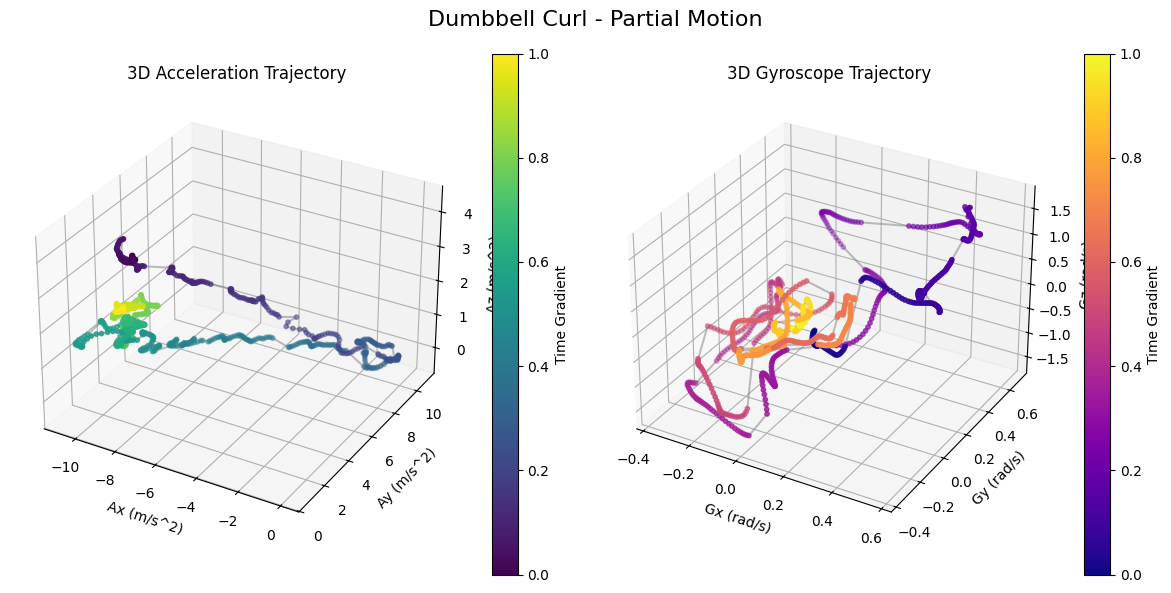

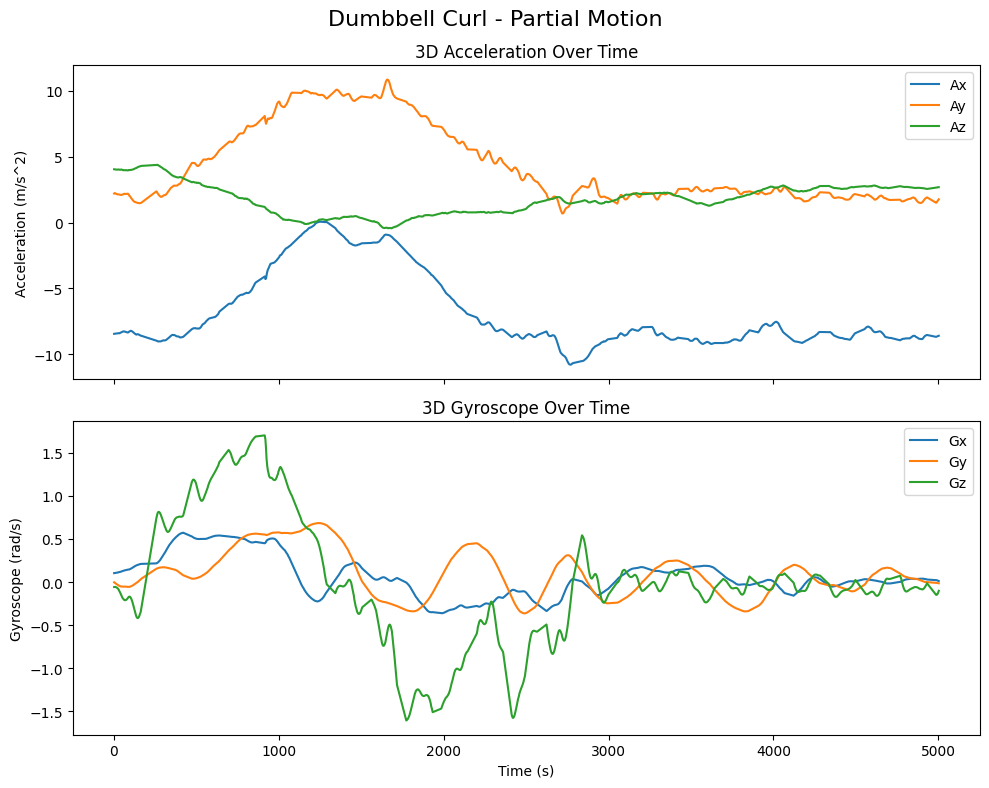

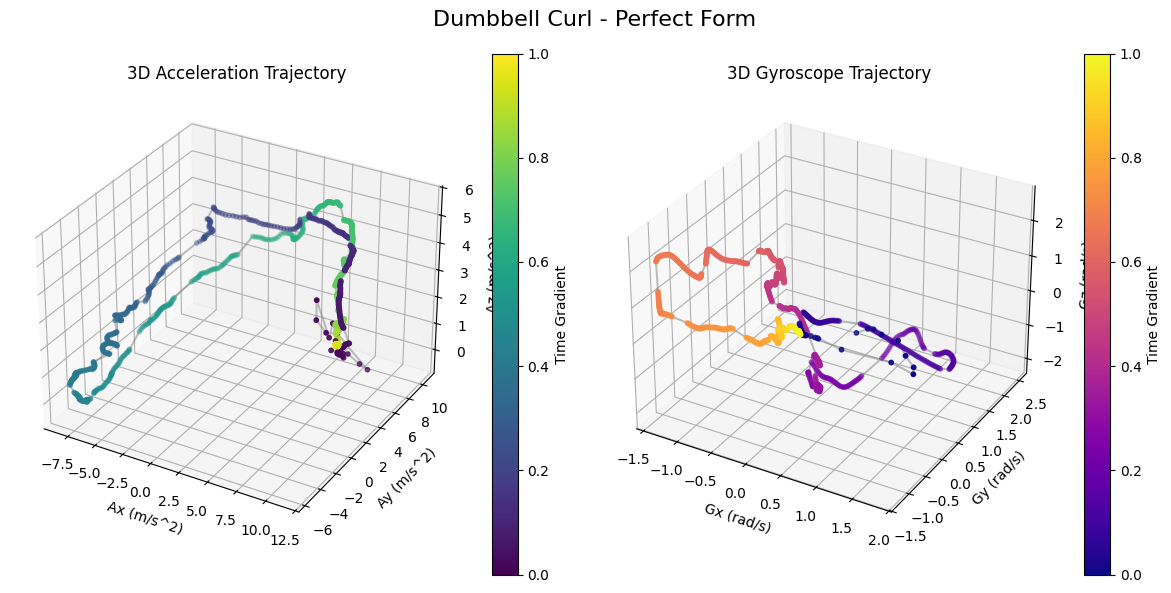

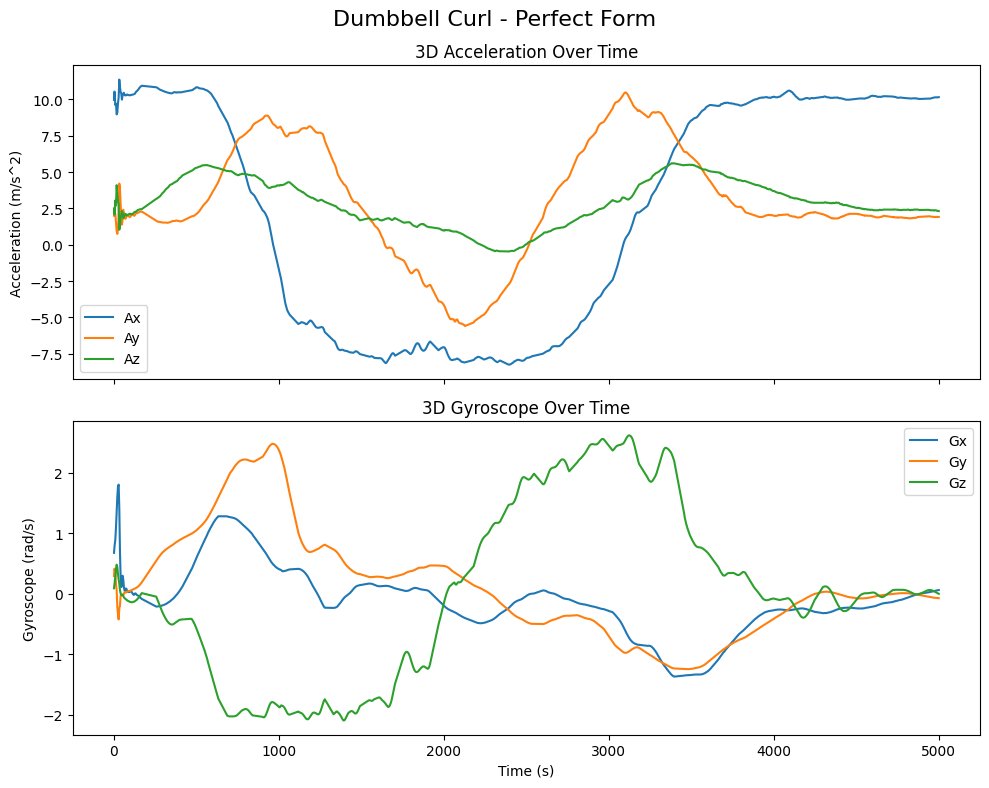

In [43]:
SAVE = False
SHOW = False

if SAVE or SHOW:
  for i in [16, 28, 55, 99, 231]:
    data = DATASET[i]
    plot_3d_trajectory(data, show=SHOW, save=SAVE)
    plot_flat_dataset(data, show=SHOW, save=SAVE)

In [14]:
TEST_PERCENTAGE = 10
VALIDATION_PERCENTAGE = 15
TRAIN_PERCENTAGE = 100 - (TEST_PERCENTAGE + VALIDATION_PERCENTAGE)

In [15]:
NUM_CLASSES = len(LIFT_CLASSES)